In [8]:
import argparse
import os
import glob
import random
import time
import cv2
import numpy as np
import darknet
import darknet_images




# LOAD and CONFIG
txt_input = "../FIRELOC_DATA/train.txt"
batch_size = True
weights = "../FIRELOC_DATA/yolov4.weights"
dont_show = True
ext_output = True
save_labels = True
config_file = "cfg/yolov4.cfg"
data_file = "cfg/coco.data"
thresh = 0.25

images = darknet_images.load_images(txt_input)
image_name = images[0]
network, class_names, class_colors = darknet.load_network(
        config_file,
        data_file,
        weights,
        batch_size
)

# pick class index out of the top 5 classes
# in the dog.jpg example:
# 0 is plant
# 1 is truck
# 2 is bicycle
# 3 is dog
# how many samples to use in explain_instance
num_samples = 2000
# how many features maximum can be used in the explanation (default is 100000)
num_features = 100000000



#---------------------------------------------------------------------------------------------

width = darknet.network_width(network)
height = darknet.network_height(network)
image = cv2.imread(image_name)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_resized = cv2.resize(image_rgb, (width, height),
                            interpolation=cv2.INTER_LINEAR)



def grey_out(image, x, y, w, h):
    # input: ndarray returned by imread, height and width
    #Create an array of object rect which represents the region of interest
    rect = [[x-w/2,y+h/2], [x-w/2,y-h/2], [x+w/2,y-h/2],[x+w/2,y+h/2]]
    mask = np.array([rect], dtype=np.int32)

    #Create a new array filled with zeros, size equal to size of the image to be filtered
    image2 = np.zeros((width, height), np.int8)

    cv2.fillPoly(image2, [mask],255)    
    maskimage2 = cv2.inRange(image2, 1, 255)
    out = cv2.bitwise_and(image, image, mask=maskimage2)
    #cv2.imshow("img",out)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    return out



# so funciona para uma imagem
def funcao_classificacao_lime(image_numpy):

    probabilities = np.zeros((len(image_numpy), len(class_names)))
    for i in range(len(image_numpy)):
        img = image_numpy[i]
        image, detections = darknet_images.image_detection_lime(
                img, network, class_names,
                class_colors, thresh
                )

        if save_labels:
            darknet_images.save_annotations(image_name, image, detections, class_names)
        #darknet.print_detections(detections, ext_output)
        if not dont_show:
            cv2.imshow('Inference', image)
            if cv2.waitKey() & 0xFF == ord('q'):
                return

        with open("probabilityArray.txt","r") as prob_array:
            lines = [float(line.rstrip()) for line in prob_array]
            probabilities[i] = lines
    return probabilities


def get_most_confident_bbox(class_name):
    # First run through Yolo to check if
    image_original, detections = darknet_images.image_detection(
                image_name, network, class_names,
                class_colors, thresh
                )
    darknet.print_detections(detections, ext_output)
    # take the detection that had the most confidence and write the coordinates to a txt file
    #detections is a list of tuples (class, confidence,(coordinates))
    picked_class = -1
    for i in range(len(detections)):
        _tuple = detections[i]
        if _tuple[0] == class_name:
            coordinates = _tuple[2]
            with open("coordinates.txt","w+") as coord_file:
                # we convert the coordinates to relative because that's how it is used in the C files
                coordinates_rel = darknet_images.convert2relative(image_original,coordinates)
                for _coord in coordinates_rel:
                    coord_file.write(str(_coord)+"\n")
                picked_class = i
            break
    return picked_class, detections




In [9]:

class_name = 'dog'
picked_class, coordinates = get_most_confident_bbox(class_name)




Objects:
pottedplant: 33.34%    (left_x: 554   top_y:  139   width:   29   height:  48)
truck: 91.79%    (left_x: 455   top_y:  130   width:   175   height:  99)
bicycle: 92.37%    (left_x: 272   top_y:  292   width:   363   height:  316)
dog: 97.91%    (left_x: 175   top_y:  404   width:   146   height:  334)


In [10]:


# pass the image, the height and width
greyed_out_image = grey_out(image_resized, coordinates[picked_class][2][0], coordinates[picked_class][2][1],coordinates[picked_class][2][2], coordinates[picked_class][2][3])


In [11]:


from lime import lime_image
#Objeto do tipo LimeImageExplainer
explainer = lime_image.LimeImageExplainer()
#Objeto do tipo ImageExplanation
explanation = explainer.explain_instance(np.array(greyed_out_image), 
                                         funcao_classificacao_lime, # classification function
                                         top_labels=5, 
                                         hide_color=0, 
                                         num_samples=num_samples,
                                         num_features=num_features) # number of images that will be sent to classification function
    



100%|██████████| 2000/2000 [02:47<00:00, 11.96it/s]


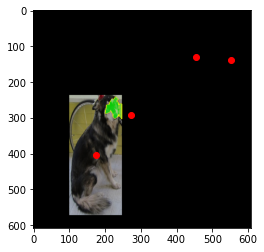

In [29]:


import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],\
    positive_only=False, num_features=1, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)
#mostrar centros das bounding boxes 
plt.scatter([coordinates[0][2][0], coordinates[1][2][0], coordinates[2][2][0], coordinates[3][2][0]],\
        [coordinates[0][2][1], coordinates[1][2][1], coordinates[2][2][1], coordinates[3][2][1]],\
        marker='o', color="red")
plt.show()

In [20]:
def crop_img(img, new_filename, coordinates, picked_class):
    [center_x, center_y, width, height] = [coord for coord in coordinates[picked_class][2]]
    top_left_x = round(center_x - width/2)
    top_left_y = round(center_y - height/2)
    crop_img = img[top_left_y:top_left_y+height, top_left_x:top_left_x+width]
    plt.imshow(crop_img)
    plt.show()
    # guardo a nova imagem num ficheiro
    cv2.imwrite(new_filename,crop_img)


In [18]:
crop_img(img_boundry2, "explanationHere.jpg", coordinates, picked_class)

TypeError: slice indices must be integers or None or have an __index__ method